In [1]:
import os
import sys
import absl
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from time import time
from numba import njit
import h5py
import plotting_figures as myplots

parentDir = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
sys.path.append(os.path.join(parentDir, "general_utils"))
import file_management
sys.path.append(os.path.join(parentDir, "billeh_model_utils"))
import other_billeh_utils, load_sparse

mpl.style.use('default')
np.random.seed(3000)

In [2]:
orientation = 0
frequency = 2
reverse = False
n_neurons = 230924
neuron_population = 'e23'
simulation_length = 2500
directory = f'orien_{str(orientation)}_freq_{str(frequency)}_reverse_{str(reverse)}_rec_{n_neurons}'
full_path = os.path.join('Simulation_results', directory)
full_data_path = os.path.join(full_path, 'Data', 'simulation_data.hdf5')
images_path = os.path.join('Images_general', 'Model representation')

In [3]:
sim_data, sim_metadata, n_simulations = other_billeh_utils.load_simulation_results_hdf5(full_data_path, n_simulations=1, skip_first_simulation=False, variables=['z'])

In [4]:
load_fn = load_sparse.cached_load_billeh
_, network, _, _ = load_fn(sim_metadata['n_input'], n_neurons, sim_metadata['core_only'], 
                            sim_metadata['data_dir'], seed=sim_metadata['seed'], connected_selection=sim_metadata['connected_selection'], 
                            n_output=sim_metadata['n_output'], neurons_per_output=sim_metadata['neurons_per_output'])

> Sucessfully restored Billeh model from /home/jgalvan/Desktop/Neurocoding/V1_Billeh_model/billeh_model_utils/.cache/billeh_network_in17400_rec230924_s3000_cFalse_conTrue_out2_nper16.pkl


In [5]:
sim_metadata['data_dir']

'/home/jgalvan/Desktop/Neurocoding/Billeh_model/GLIF_network'

In [6]:
data_dir = '/home/jgalvan/Desktop/Neurocoding/V1_Billeh_model/GLIF_network'
data_dir

'/home/jgalvan/Desktop/Neurocoding/V1_Billeh_model/GLIF_network'

In [7]:
# get the neuron names
population_names = other_billeh_utils.pop_names(network, data_dir=data_dir)
population_names = np.array([pop_name if pop_name[0]=='i' else pop_name[:2] for pop_name in population_names])

In [8]:
# Selection of the candidate neurons
percentage_of_selected_neurons = 0.01
max_radius = 400
# network = file_management.load_lzma(os.path.join(full_data_path, 'network.lzma'))

pop_dict = {}
for pop_name in np.unique(population_names):
    if pop_name[0]=='e':
        pop_color = 'darkred'
        alpha = 0.4
    elif 'Pvalb' in pop_name:
        pop_color = 'darkblue'
        alpha = 1
    elif 'Sst' in pop_name:
        pop_color = 'darkgreen' # lime
        alpha = 1
    elif 'Htr3a' in pop_name:
        pop_color = 'darkviolet'
        alpha = 1
    tf_indices = np.arange(n_neurons)[population_names == pop_name]
    # select neurons with a radius lower than 400 
    x_pop = network['x'][tf_indices]
    z_pop = network['z'][tf_indices]
    radius = np.sqrt(x_pop**2 + z_pop**2)
    tf_indices = tf_indices[radius < max_radius]
    pop_size = len(tf_indices)
    # select a random sample of the neurons
    selected_tf_indices = np.random.choice(tf_indices, size=int(pop_size*percentage_of_selected_neurons), replace=False)
    pop_dict[pop_name] = {'indices': selected_tf_indices,
                          'x': network['x'][selected_tf_indices],
                          'y': network['y'][selected_tf_indices],
                          'z': network['z'][selected_tf_indices],
                          'color':pop_color,
                          'alpha':alpha}                      

## Simple network representation (dark background)

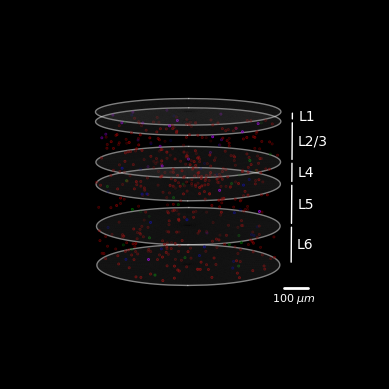

In [58]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for pop_name in pop_dict.keys():
    x = pop_dict[pop_name]['x']
    y = pop_dict[pop_name]['y']
    z = pop_dict[pop_name]['z']
    color = pop_dict[pop_name]['color']
    ax.scatter(x, z, y, 'o', s=0.3, color=color)

x_circ = np.linspace(-400, 400, 100)
z_circ = np.sqrt(400**2 - x_circ**2)
x_vert = np.zeros((100))
z_vert = 450*np.ones((100))
R = np.linspace(0, 400, 100)
u = np.linspace(0,  2*np.pi, 100)
x = np.outer(R, np.cos(u))
z = np.outer(R, np.sin(u))
upper_limit = -50
layer_limits = [-100, -310, -425, -645, -850]
layers = ['L1', 'L2/3', 'L4', 'L5', 'L6']
ax.plot(x_circ, z_circ, -50, color='white', linewidth=1, alpha=0.5)
ax.plot(x_circ, -z_circ, -50, color='white', linewidth=1, alpha=0.5)
ax.plot_surface(x,z,upper_limit*np.ones(x.shape), alpha=0.15, color='white', linewidth=0)    
for layer, lower_limit in zip(layers, layer_limits):
    ax.plot(x_circ, z_circ, lower_limit, color='white', linewidth=1, alpha=0.5)
    ax.plot(x_circ, -z_circ, lower_limit, color='white', linewidth=1, alpha=0.5)
    ax.plot_surface(x,z,lower_limit*np.ones(x.shape), alpha=0.15, color='white', linewidth=0)
    # Lateral layers legend
    ax.plot(np.zeros((100)), 450*np.ones((100)), np.linspace(lower_limit+10, upper_limit-10, 100), color='white', linewidth=1, alpha=1)
    ax.text(0, 475, np.mean([lower_limit, upper_limit]), layer, color='white', fontsize=10, verticalalignment='center')
    upper_limit = lower_limit
    
z_scale = np.linspace(400, 500, 100)
x_scale = 450*np.ones(100)
y_scale = -850*np.ones(100)
ax.plot(x_scale, z_scale, y_scale, color='white', linewidth=2, alpha=1)    
ax.text(670, 430, -850, r'100 $\mu m$', color='white', fontsize=8, horizontalalignment='center')

# Vertical bars from the cylinder
# y = np.linspace(-50, -850, 100)
# x = np.zeros(100)
# z = 400*np.ones(100)
# ax.plot(x, z, y, color='white', linewidth=1, alpha=0.7)    
# ax.plot(x, -z, y, color='white', linewidth=1, alpha=0.7)    

plt.axis('off')
ax.view_init(elev=10, azim=0)
plt.savefig(os.path.join(images_path, "model_representation.png"), dpi=300, transparent=True)
plt.show()

## V1 core network representation (white background)

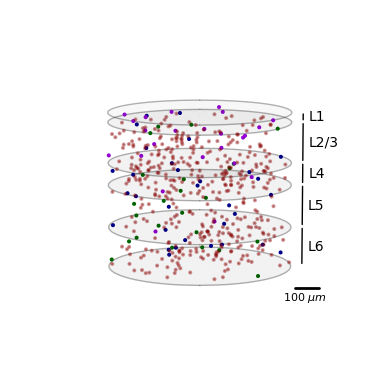

In [52]:
sns.set(style="ticks", context="talk")
# plt.style.use('classic')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for pop_name in pop_dict.keys():
    x = pop_dict[pop_name]['x']
    y = pop_dict[pop_name]['y']
    z = pop_dict[pop_name]['z']
    color = pop_dict[pop_name]['color']
    alpha = pop_dict[pop_name]['alpha']
    ax.scatter(x, z, y, 'o', alpha=alpha, s=2, color=color)

x_circ = np.linspace(-400, 400, 100)
z_circ = np.sqrt(400**2 - x_circ**2)
x_vert = np.zeros((100))
z_vert = 450*np.ones((100))
R = np.linspace(0, 400, 100)
u = np.linspace(0,  2*np.pi, 100)
x = np.outer(R, np.cos(u))
z = np.outer(R, np.sin(u))
upper_limit = -50
layer_limits = [-100, -310, -425, -645, -850]
layers = ['L1', 'L2/3', 'L4', 'L5', 'L6']
ax.plot(x_circ, z_circ, -50, color='black', linewidth=1, alpha=0.3)
ax.plot(x_circ, -z_circ, -50, color='black', linewidth=1, alpha=0.3)
ax.plot_surface(x,z,upper_limit*np.ones(x.shape), alpha=0.05, color='white', linewidth=0)    
for layer, lower_limit in zip(layers, layer_limits):
    ax.plot(x_circ, z_circ, lower_limit, color='black', linewidth=1, alpha=0.3)
    ax.plot(x_circ, -z_circ, lower_limit, color='black', linewidth=1, alpha=0.3)
    ax.plot_surface(x,z,lower_limit*np.ones(x.shape), alpha=0.05, color='black', linewidth=0)
    # Lateral layers legend
    ax.plot(np.zeros((100)), 450*np.ones((100)), np.linspace(lower_limit+10, upper_limit-10, 100), color='black', linewidth=1, alpha=1)
    ax.text(0, 475, np.mean([lower_limit, upper_limit]), layer, color='black', fontsize=10, verticalalignment='center')
    upper_limit = lower_limit
    
z_scale = np.linspace(400, 500, 100)
x_scale = 450*np.ones(100)
y_scale = -850*np.ones(100)
ax.plot(x_scale, z_scale, y_scale, color='black', linewidth=2, alpha=1)    
ax.text(670, 430, -850, r'100 $\mu m$', color='black', fontsize=8, horizontalalignment='center')

# Vertical bars from the cylinder
# y = np.linspace(-50, -850, 100)
# x = np.zeros(100)
# z = 400*np.ones(100)
# ax.plot(x, z, y, color='white', linewidth=1, alpha=0.7)    
# ax.plot(x, -z, y, color='white', linewidth=1, alpha=0.7)    

#set lims to the axis
plt.xlim(-500, 500)
plt.ylim(-500, 500)

plt.axis('off')
ax.view_init(elev=10, azim=0)
# plt.tight_layout()
plt.savefig(os.path.join(images_path, "model_representation_white.png"), dpi=300, transparent=True)
plt.show()

## Readout population representation (white background)

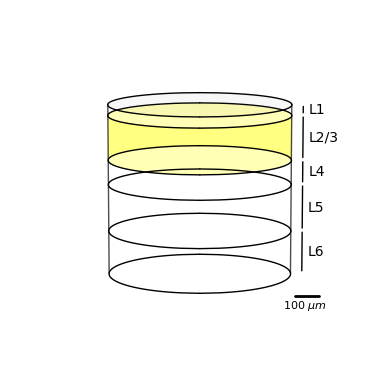

In [40]:
sns.set(style="ticks", context="talk")
# plt.style.use('classic')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x_circ = np.linspace(-400, 400, 100)
z_circ = np.sqrt(400**2 - x_circ**2)
x_vert = np.zeros((100))
z_vert = 450*np.ones((100))
R = np.linspace(0, 400, 100)
u = np.linspace(0,  2*np.pi, 100)
x = np.outer(R, np.cos(u))
z = np.outer(R, np.sin(u))
upper_limit = -50
layer_limits = [-100, -310, -425, -645, -850]
layers = ['L1', 'L2/3', 'L4', 'L5', 'L6']
ax.plot(x_circ, z_circ, -50, color='black', linewidth=1, alpha=1)
ax.plot(x_circ, -z_circ, -50, color='black', linewidth=1, alpha=1)
ax.plot_surface(x,z,upper_limit*np.ones(x.shape), alpha=0.05, color='white', linewidth=0)    

for layer, lower_limit in zip(layers, layer_limits):
    ax.plot(x_circ, z_circ, lower_limit, color='black', linewidth=1, alpha=1)
    ax.plot(x_circ, -z_circ, lower_limit, color='black', linewidth=1, alpha=1)

    # Lateral layers legend
    ax.plot(np.zeros((100)), 450 * np.ones((100)), np.linspace(lower_limit + 10, upper_limit - 10, 100), color='black', linewidth=1, alpha=1)
    ax.text(0, 475, np.mean([lower_limit, upper_limit]), layer, color='black', fontsize=10, verticalalignment='center')
    upper_limit = lower_limit

z_scale = np.linspace(400, 500, 100)
x_scale = 450*np.ones(100)
y_scale = -850*np.ones(100)
ax.plot(x_scale, z_scale, y_scale, color='black', linewidth=2, alpha=1)    
ax.text(670, 430, -850, r'100 $\mu m$', color='black', fontsize=8, horizontalalignment='center')

# Vertical bars from the cylinder
y = np.linspace(-50, -850, 100)
x = np.zeros(100)
z = 400*np.ones(100)
ax.plot(x, z, y, color='black', linewidth=1, alpha=0.7)    
ax.plot(x, -z, y, color='black', linewidth=1, alpha=0.7)    

us = np.linspace(np.pi, 3 * np.pi, 1000)
zs = np.linspace(-100, -310, 1000)
us, zs = np.meshgrid(us, zs)
xs = 400 * np.cos(us)
ys = 400 * np.sin(us)
ax.plot_surface(xs, ys, zs, alpha=0.3, color='yellow', linewidth=0, shade=False)

#set lims to the axis
plt.xlim(-500, 500)
plt.ylim(-500, 500)

plt.axis('off')
ax.view_init(elev=10, azim=0)
# plt.tight_layout()
plt.savefig(os.path.join(images_path, "model_L23_highlighting.png"), dpi=300, transparent=True)
plt.show()

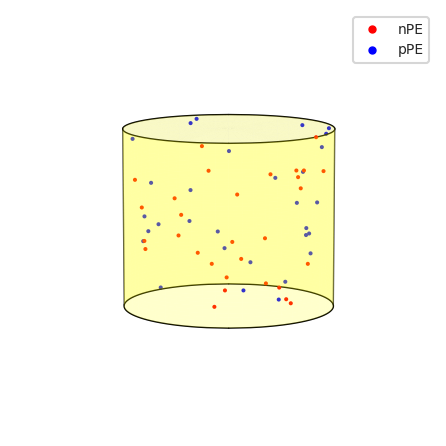

In [51]:
sns.set(style="ticks", context="talk")

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

radius = 400

x_circ = np.linspace(-radius, radius, 100)
z_circ = np.sqrt(radius**2 - x_circ**2)
x_vert = np.zeros((100))
z_vert = 450*np.ones((100))
R = np.linspace(0, radius, 100)
u = np.linspace(0,  2*np.pi, 100)
x = np.outer(R, np.cos(u))
z = np.outer(R, np.sin(u))
upper_limit = -100
lower_limit= -310
ax.plot(x_circ, z_circ, upper_limit, color='black', linewidth=1, alpha=1)
ax.plot(x_circ, -z_circ, upper_limit, color='black', linewidth=1, alpha=1)
ax.plot(x_circ, z_circ, lower_limit, color='black', linewidth=1, alpha=1)
ax.plot(x_circ, -z_circ, lower_limit, color='black', linewidth=1, alpha=1)
ax.plot_surface(x,z,upper_limit*np.ones(x.shape), alpha=0.05, color='white', linewidth=0)    

# Vertical bars from the cylinder
y = np.linspace(upper_limit, lower_limit, 100)
x = np.zeros(100)
z = radius*np.ones(100)
ax.plot(x, z, y, color='black', linewidth=1, alpha=0.7)    
ax.plot(x, -z, y, color='black', linewidth=1, alpha=0.7)    

us = np.linspace(0, 2 * np.pi, 1000)
zs = np.linspace(upper_limit, lower_limit, 1000)
us, zs = np.meshgrid(us, zs)
xs = radius * np.cos(us)
ys = radius * np.sin(us)
ax.plot_surface(xs, ys, zs, alpha=0.2, color='yellow', linewidth=0, shade=False)

# randomly scatter 30 points inside the cylinder
n_points = 30
theta = np.random.uniform(0, 2*np.pi, n_points)
y = np.random.uniform(upper_limit, lower_limit, n_points)
x = np.sqrt(radius**2 - y**2) * np.cos(theta)
z = np.sqrt(radius**2 - y**2) * np.sin(theta)
ax.scatter(x, z, y, 'o', alpha=1, s=2, color='red')

# randomly scatter 30 points inside the cylinder
theta = np.random.uniform(0, 2*np.pi, n_points)
y = np.random.uniform(upper_limit, lower_limit, n_points)
x = np.sqrt(radius**2 - y**2) * np.cos(theta)
z = np.sqrt(radius**2 - y**2) * np.sin(theta)
ax.scatter(x, z, y, 'o', alpha=1, s=2, color='blue')

# Create proxy artists for the legend
red_legend = plt.Line2D([0], [0], linestyle='none', marker='o', markersize=5, color='red', label='nPE')
blue_legend = plt.Line2D([0], [0], linestyle='none', marker='o', markersize=5, color='blue', label='pPE')
# Add the legend to the plot
legend = ax.legend(handles=[red_legend, blue_legend], loc='upper right', fontsize=10)

#set lims to the axis
plt.xlim(-500, 500)
plt.ylim(-500, 500)

plt.axis('off')
ax.view_init(elev=10, azim=0)
plt.tight_layout()
plt.savefig(os.path.join(images_path, "L23_PE_neurons.png"), dpi=300, transparent=True)
plt.show()

### LM column representation

In [55]:
percentage_of_selected_neurons = 0.015
max_radius = 152.2
# network = file_management.load_lzma(os.path.join(full_data_path, 'network.lzma'))

pop_dict = {}
for pop_name in np.unique(population_names):
    if pop_name[0]=='e':
        pop_color = 'darkred'
        alpha = 0.4
    elif 'Pvalb' in pop_name:
        pop_color = 'darkblue'
        alpha = 1
    elif 'Sst' in pop_name:
        pop_color = 'darkgreen' # lime
        alpha = 1
    elif 'Htr3a' in pop_name:
        pop_color = 'darkviolet'
        alpha = 1
    tf_indices = np.arange(n_neurons)[population_names == pop_name]
    # select neurons with a radius lower than 400 
    x_pop = network['x'][tf_indices]
    z_pop = network['z'][tf_indices]
    radius = np.sqrt(x_pop**2 + z_pop**2)
    tf_indices = tf_indices[radius < max_radius]
    pop_size = len(tf_indices)
    # select a random sample of the neurons
    selected_tf_indices = np.random.choice(tf_indices, size=int(pop_size*percentage_of_selected_neurons), replace=False)
    pop_dict[pop_name] = {'indices': selected_tf_indices,
                          'x': network['x'][selected_tf_indices],
                          'y': network['y'][selected_tf_indices],
                          'z': network['z'][selected_tf_indices],
                          'color':pop_color,
                          'alpha':alpha}                      

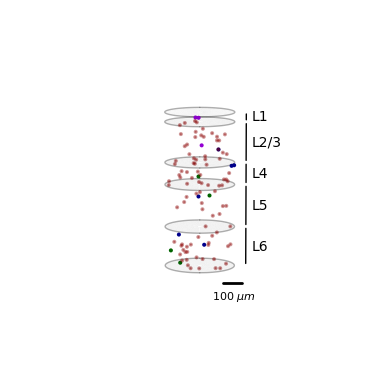

In [56]:
sns.set(style="ticks", context="talk")
# plt.style.use('classic')
max_radius = 152.42

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for pop_name in pop_dict.keys():
    x = pop_dict[pop_name]['x']
    y = pop_dict[pop_name]['y']
    z = pop_dict[pop_name]['z']
    color = pop_dict[pop_name]['color']
    alpha = pop_dict[pop_name]['alpha']
    ax.scatter(x, z, y, 'o', alpha=alpha, s=2, color=color)

x_circ = np.linspace(-max_radius, max_radius, 100)
z_circ = np.sqrt(max_radius**2 - x_circ**2)
x_vert = np.zeros((100))
z_vert = 450*np.ones((100))
R = np.linspace(0, max_radius, 100)
u = np.linspace(0,  2*np.pi, 100)
x = np.outer(R, np.cos(u))
z = np.outer(R, np.sin(u))
upper_limit = -50
layer_limits = [-100, -310, -425, -645, -850]
layers = ['L1', 'L2/3', 'L4', 'L5', 'L6']
ax.plot(x_circ, z_circ, -50, color='black', linewidth=1, alpha=0.3)
ax.plot(x_circ, -z_circ, -50, color='black', linewidth=1, alpha=0.3)
ax.plot_surface(x,z,upper_limit*np.ones(x.shape), alpha=0.05, color='white', linewidth=0)    
for layer, lower_limit in zip(layers, layer_limits):
    ax.plot(x_circ, z_circ, lower_limit, color='black', linewidth=1, alpha=0.3)
    ax.plot(x_circ, -z_circ, lower_limit, color='black', linewidth=1, alpha=0.3)
    ax.plot_surface(x,z,lower_limit*np.ones(x.shape), alpha=0.05, color='black', linewidth=0)
    # Lateral layers legend
    ax.plot(np.zeros((100)), (max_radius+50)*np.ones((100)), np.linspace(lower_limit+10, upper_limit-10, 100), color='black', linewidth=1, alpha=1)
    ax.text(0, (max_radius+75), np.mean([lower_limit, upper_limit]), layer, color='black', fontsize=10, verticalalignment='center')
    upper_limit = lower_limit
    
z_scale = np.linspace(100, 180, 100)
x_scale = 350*np.ones(100)
y_scale = -850*np.ones(100)
ax.plot(x_scale, z_scale, y_scale, color='black', linewidth=2, alpha=1)    
ax.text(650, 140, -850, r'100 $\mu m$', color='black', fontsize=8, horizontalalignment='center')

# Vertical bars from the cylinder
# y = np.linspace(-50, -850, 100)
# x = np.zeros(100)
# z = 400*np.ones(100)
# ax.plot(x, z, y, color='white', linewidth=1, alpha=0.7)    
# ax.plot(x, -z, y, color='white', linewidth=1, alpha=0.7)    

plt.xlim(-500, 500)
plt.ylim(-500, 500)

# set lim to every axis
# ax.set_xlim(-500, 500)
# ax.set_ylim(-500, 500)


plt.axis('off')
ax.view_init(elev=10, azim=0)
plt.savefig(os.path.join(images_path, "LM_model_representation_white.png"), dpi=300, transparent=True)
plt.show()

## GIF from the network representation

In [6]:
import imageio
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
    
filenames = []
for azimuth in np.linspace(0, 2*np.pi, 100):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for pop_name in pop_dict.keys():
        x = pop_dict[pop_name]['x']
        y = pop_dict[pop_name]['y']
        z = pop_dict[pop_name]['z']
        color = pop_dict[pop_name]['color']
        radius = np.sqrt(x**2 + z**2)
        angle = np.arctan2(z, x)
        ax.scatter(radius*np.cos(angle+azimuth), radius*np.sin(angle+azimuth), y, 'o', s=0.5, color=color)

    x_circ = np.linspace(-400, 400, 100)
    z_circ = np.sqrt(400**2 - x_circ**2)
    x_vert = np.zeros((100))
    z_vert = 450*np.ones((100))
    R = np.linspace(0, 400, 100)
    u = np.linspace(0,  2*np.pi, 100)
    x = np.outer(R, np.cos(u))
    z = np.outer(R, np.sin(u))
    upper_limit = -50
    layer_limits = [-100, -310, -425, -645, -850]
    layers = ['L1', 'L2/3', 'L4', 'L5', 'L6']
    ax.plot(x_circ, z_circ, -50, color='white', linewidth=1, alpha=0.5)
    ax.plot(x_circ, -z_circ, -50, color='white', linewidth=1, alpha=0.5)
    ax.plot_surface(x,z,upper_limit*np.ones(x.shape), alpha=0.15, color='white', linewidth=0)    
    for layer, lower_limit in zip(layers, layer_limits):
        ax.plot(x_circ, z_circ, lower_limit, color='white', linewidth=1, alpha=0.5)
        ax.plot(x_circ, -z_circ, lower_limit, color='white', linewidth=1, alpha=0.5)
        ax.plot_surface(x,z,lower_limit*np.ones(x.shape), alpha=0.15, color='white', linewidth=0)
        # Lateral layers legend
        ax.plot(np.zeros((100)), 450*np.ones((100)), np.linspace(lower_limit+10, upper_limit-10, 100), color='white', linewidth=1, alpha=1)
        ax.text(0, 475, np.mean([lower_limit, upper_limit]), layer, color='white', fontsize=10, verticalalignment='center')
        upper_limit = lower_limit

    z_scale = np.linspace(400, 500, 100)
    x_scale = 450*np.ones(100)
    y_scale = -850*np.ones(100)
    ax.plot(x_scale, z_scale, y_scale, color='white', linewidth=2, alpha=1)    
    ax.text(670, 430, -850, r'100 $\mu m$', color='white', fontsize=8, horizontalalignment='center')

    # create file name and append it to a list
    filename = f'{azimuth}.png'
    filenames.append(filename)
    
    # save frame
    plt.axis('off')
    ax.view_init(elev=10, azim=0)
    plt.savefig(filename, dpi=300, transparent=True)
    plt.close()

# build gif
with imageio.get_writer(os.path.join(images_path, "model_representation.gif"), mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)